In [27]:

from numpy import array

#from statistics import mean as mean
#from statistics import stdev as stddev
import matplotlib.pyplot as plt
import time

In [28]:
import numpy as np
N_digits = 50
#N_digits = 60000
D_Size = 784
D_bytes = N_digits * D_Size
D_rows = N_digits * 28

MNIST_file = open ("train-images.idx3-ubyte","rb")
z = MNIST_file.read (16 + D_bytes)
len (z)
digits_raw = z[16:(16 + D_bytes)]
w = np.empty (shape=(D_rows, 28))
print (len (digits_raw))
for i in range (0, D_rows) :
    for j in range (0,28) :
        w[i, j] = float (digits_raw[i*28 + j])/255
Training = w.reshape (N_digits, 28, 28)
np.shape (Training)
counter = 0
spikearray = []
spike_array = []
#print(Training[0])
for i in range(0,len(Training)):
    for j in range(0,28):
        for k in range(0,28):
            if Training[i,j,k] >= 0.5:
                Training[i,j,k] = counter
                spike_array.append(Training[i,j,k])
            else:
                Training[i,j,k] = 0
            counter+=1
spikearray = spike_array

39200


In [29]:
Labels_file = open ("train-labels.idx1-ubyte","rb")
Labels_raw = Labels_file.read (8 + N_digits)
Labels = np.empty (N_digits)
for i in range (0, N_digits):
    Labels[i] = int (Labels_raw[8 + i])
# The classes of the digits, 0:9
Answers = range (0, 10)

#Labels = to_categorical(Labels)
#print(Labels[8])
#print(Training[8])

In [30]:
ALIF_neuron_parameters_inh = {
    'v_rest':   -70.6,  # Resting membrane potential in mV.
    'cm':         0.281,  # Capacity of the membrane in nF
    'tau_m':     9.3667,  # Membrane time constant in ms.
    'tau_refrac': 0.0,  # Duration of refractory period in ms.
    'tau_syn_E':  5.0,  # Decay time of the excitatory synaptic conductance in ms.
    'tau_syn_I':  5.0,  # Decay time of the inhibitory synaptic conductance in ms.
    'e_rev_E':    0.0,  # Reversal potential for excitatory input in mV
    'e_rev_I':  -80.0,  # Reversal potential for inhibitory input in mV
    'v_thresh': -50.4,  # Spike threshold in mV.
    'v_reset':  -70.6,  # Reset potential after a spike in mV.
    'i_offset':   0.0,  # Offset current in nA
}
ALIF_neuron_parameters_exc = {
    'v_rest':   -70.6,  # Resting membrane potential in mV.
    'cm':         0.281,  # Capacity of the membrane in nF
    'tau_m':     9.3667,  # Membrane time constant in ms.
    'tau_refrac': 0.0,  # Duration of refractory period in ms.
    'tau_syn_E':  5.0,  # Decay time of the excitatory synaptic conductance in ms.
    'tau_syn_I':  5.0,  # Decay time of the inhibitory synaptic conductance in ms.
    'e_rev_E':    80.0,  # Reversal potential for excitatory input in mV
    'e_rev_I':  0.0,  # Reversal potential for inhibitory input in mV
    'v_thresh': -50.4,  # Spike threshold in mV.
    'v_reset':  -70.6,  # Reset potential after a spike in mV.
    'i_offset':   0.0,  # Offset current in nA
}

In [31]:

import spynnaker8 as sim
import pyNN.utility.plotting as plot
import matplotlib.pyplot as plt


batchsize = N_digits
simtime = 28*28*batchsize
#simtime = 750*batchsize*2
n_neurons = 100
sim.setup(timestep=1,time_scale_factor=10)
input_neuron_count = 784

pre_alif_pop = sim.Population(n_neurons,
                              sim.IF_cond_exp(**ALIF_neuron_parameters_inh),
                              initial_values={'v': ALIF_neuron_parameters_inh["v_rest"]},label="PreAlif")
post_alif_pop = sim.Population(n_neurons, 
                               sim.IF_cond_exp(**ALIF_neuron_parameters_exc),
                               initial_values={'v': ALIF_neuron_parameters_exc["v_rest"]},label="PostAlif")

pre_alif_pop.record(["spikes",'v','gsyn_inh','gsyn_exc'])
post_alif_pop.record(["spikes",'v','gsyn_exc','gsyn_inh'])

%matplotlib inline

inp = sim.Population(input_neuron_count,
                   sim.SpikeSourceArray(spikearray),
                   label="Input"
                  )
output = sim.Population(10,
                    sim.IF_cond_exp(**ALIF_neuron_parameters_exc),
                    initial_values={'v': ALIF_neuron_parameters_exc["v_rest"]},label="PostAlif"
                    )
output.record(["spikes"])
stdp_initial_weights = sim.RandomDistribution(distribution='normal_clipped',low=0,high=1, mu=0.5, sigma=0.3)
sim.Projection(presynaptic_population = post_alif_pop,
             postsynaptic_population = pre_alif_pop,
             connector = sim.OneToOneConnector(),
             synapse_type = sim.StaticSynapse(weight=1,delay=1.0),
             receptor_type = 'excitatory'
            )
i_e_connection_list = []
for i in range(n_neurons):
    for j in range(n_neurons):
        if not i==j:
            i_e_connection_list.append((i,j))
sim.Projection(presynaptic_population = pre_alif_pop,
             postsynaptic_population = post_alif_pop,
             connector = sim.FromListConnector(i_e_connection_list),
             synapse_type = sim.StaticSynapse(weight=0.0625,delay=1.0), # 0.0001
             receptor_type = 'inhibitory'
            )
sim.Projection(post_alif_pop,post_alif_pop,sim.AllToAllConnector(),
               synapse_type=sim.StaticSynapse(weight=0.285),
               receptor_type = 'excitatory')#recurrent
sim.Projection(pre_alif_pop,pre_alif_pop,sim.AllToAllConnector(),
               synapse_type=sim.StaticSynapse(weight=0.65),
               
               receptor_type = 'inhibitory')#recurrent
sim.Projection(inp,post_alif_pop,
                sim.AllToAllConnector(),
                synapse_type=sim.StaticSynapse(weight=0.65),
                receptor_type = 'inhibitory')

timing_rule = sim.SpikePairRule(tau_plus=5.0,
                                tau_minus=2.0,
                                A_plus=0.0625,
                                A_minus=0.0625)
weight_rule = sim.AdditiveWeightDependence(w_max=5.0,w_min=0.0)
stdp_model = sim.STDPMechanism(timing_dependence=timing_rule,
                               weight_dependence=weight_rule,
                              weight=stdp_initial_weights,delay=3.0)
stdp_projection = sim.Projection(post_alif_pop,
                                 output,
                                 sim.AllToAllConnector(),
                                 synapse_type=stdp_model,
                                 receptor_type = 'excitatory')
sim.Projection(post_alif_pop,post_alif_pop,sim.AllToAllConnector(),synapse_type=sim.StaticSynapse(weight=0.185),receptor_type = 'excitatory')#recurrent
sim.Projection(pre_alif_pop,pre_alif_pop,sim.AllToAllConnector(),synapse_type=sim.StaticSynapse(weight=0.15),receptor_type = 'inhibitory')#recurrent
sim.run(simtime)

2022-05-28 11:48:32 WARNING: Calling setup a second time causes the previous simulator to be stopped and cleared.
2022-05-28 11:48:32 INFO: Caching data for segment -1
Getting spikes for PreAlif
|0%                          50%                         100%|
Getting v for PreAlif
|0%                          50%                         100%|
Getting gsyn_exc for PreAlif
|0%                          50%                         100%|
Getting gsyn_inh for PreAlif
|0%                          50%                         100%|
2022-05-28 11:48:32 INFO: Caching data for segment -1
Getting spikes for PostAlif
|0%                          50%                         100%|
Getting v for PostAlif
|0%                          50%                         100%|
Getting gsyn_exc for PostAlif
|0%                          50%                         100%|
Getting gsyn_inh for PostAlif
|0%                          50%                         100%|
2022-05-28 11:48:32 INFO: Caching data for segment -1
Ge

['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']


2022-05-28 11:48:36 INFO: Time 0:00:03.552583 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2022-05-28 11:48:46 INFO: Time 0:00:09.786576 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2022-05-28 11:48:51 INFO: Time 0:00:05.457533 taken by SpYNNakerSplitterPartitioner
Created spalloc job 6439778
2022-05-28 11:48:51 INFO: Created spalloc job 6439778
Waiting for board power commands to complete.
2022-05-28 11:48:51 INFO: Waiting for board power commands to complete.
2022-05-28 11:48:56 INFO: Time 0:00:05.048879 taken by SpallocAllocator
2022-05-28 11:48:56 INFO: Creating transceiver for 10.11.218.33
2022-05-28 11:48:56 INFO: Working out if machine is booted
2022-05-28 11:49:00 INFO: Attempting to 

39200.0

Getting spikes for PostAlif1
|0%                          50%                         100%|
Getting spikes for PostAlif
|0%                          50%                         100%|
Getting v for PreAlif
|0%                          50%                         100%|
Getting v for PostAlif
|0%                          50%                         100%|


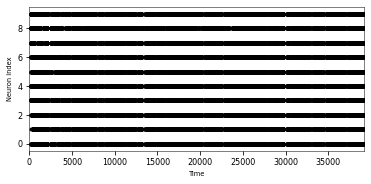

In [32]:

output_spikes = output.get_data(variables=["spikes"])
post_neo = post_alif_pop.get_data(variables=["spikes"])
post_spikes = post_neo.segments[0].spiketrains
pre_v = pre_alif_pop.get_data("v")
post_v = post_alif_pop.get_data("v")
#print(stdp_projection.getWeights())

plot.Figure(
    plot.Panel(output_spikes.segments[0].spiketrains,yticks=True,xticks=True,xlabel="Time"),
).save("OutputSpikes")

In [33]:
print(output_spikes.segments[0].spiketrains[9][0])
print(len(output_spikes.segments[0].spiketrains[1]))


162.0 ms
4550


In [34]:
weightarray = np.array(stdp_projection.getWeights())

2022-05-28 11:57:45 WARNING: getWeights is deprecated.  Use get('weight') instead
Getting synaptic data between PostAlif and PostAlif1
|0%                          50%                         100%|


In [35]:
print(weightarray)

[4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515

In [36]:


#print(weightarray)
for l in range(0,batchsize):
    for i in range(0,9):#neurons
        counter = 0
        count=len(output_spikes.segments[0].spiketrains[i])
        #print(count)
        for j in range(0,count):#
            if output_spikes.segments[0].spiketrains[i][j]:
                counter+=1
                if counter >=10:
                    if i == Labels[l]:
                        weightarray[i] += 0.13
                        if weightarray[i] >= 5:
                            weightarray[i] = 5
                        break
                        
                    else:
                        weightarray[i] -= 0.23
                        if weightarray[i] <= 0:
                            weightarray[i] = 0
                            weightarray[i] += 0.01
                        break
                        
print(weightarray)

[0.01     0.01     0.01     0.14     0.01     0.01     0.01     0.01
 0.01     4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625
 4.515625 4.515625 4.515625 4.515625 4.515625 4.515625 

In [37]:
import numpy as np
N_digits = 100
#N_digits = 60000
D_Size = 784
D_bytes = N_digits * D_Size
D_rows = N_digits * 28

MNIST_file = open ("train-images.idx3-ubyte","rb")
z = MNIST_file.read (16 + D_bytes)
len (z)
digits_raw = z[16:(16 + D_bytes)]
w = np.empty (shape=(D_rows, 28))
print (len (digits_raw))
for i in range (0, D_rows) :
    for j in range (0,28) :
        w[i, j] = float (digits_raw[i*28 + j])/255
Training = w.reshape (N_digits, 28, 28)
np.shape (Training)
counter = 0
spikearray = []
spike_array = []
#print(Training[0])
for i in range(50,len(Training)):
    for j in range(0,28):
        for k in range(0,28):
            if Training[i,j,k] >= 0.5:
                Training[i,j,k] = counter
                spike_array.append(Training[i,j,k])
            else:
                Training[i,j,k] = 0
            counter+=1
spikearray = spike_array
Labels_file = open ("train-labels.idx1-ubyte","rb")
Labels_raw = Labels_file.read (8 + N_digits)
Labels = np.empty (N_digits)
for i in range (0, N_digits):
    Labels[i] = int (Labels_raw[8 + i])
# The classes of the digits, 0:9
Answers = range (0, 10)

#Labels = to_categorical(Labels)
#print(Labels[8])
#print(Training[8])
import spynnaker8 as sim
import pyNN.utility.plotting as plot
import matplotlib.pyplot as plt


batchsize = 50
simtime = 28*28*batchsize
#simtime = 750*batchsize*2
n_neurons = 100
sim.setup(timestep=1,time_scale_factor=10)
input_neuron_count = 784

pre_alif_pop = sim.Population(n_neurons,
                              sim.IF_cond_exp(**ALIF_neuron_parameters_inh),
                              initial_values={'v': ALIF_neuron_parameters_inh["v_rest"]},label="PreAlif")
post_alif_pop = sim.Population(n_neurons, 
                               sim.IF_cond_exp(**ALIF_neuron_parameters_exc),
                               initial_values={'v': ALIF_neuron_parameters_exc["v_rest"]},label="PostAlif")

pre_alif_pop.record(["spikes",'v','gsyn_inh','gsyn_exc'])
post_alif_pop.record(["spikes",'v','gsyn_exc','gsyn_inh'])

%matplotlib inline

inp = sim.Population(input_neuron_count,
                   sim.SpikeSourceArray(spikearray),
                   label="Input"
                  )
output = sim.Population(10,
                    sim.IF_cond_exp(**ALIF_neuron_parameters_exc),
                    initial_values={'v': ALIF_neuron_parameters_exc["v_rest"]},label="PostAlif"
                    )
output.record(["spikes"])
stdp_initial_weights = sim.RandomDistribution(distribution='normal_clipped',low=0,high=1, mu=0.5, sigma=0.3)
sim.Projection(presynaptic_population = post_alif_pop,
             postsynaptic_population = pre_alif_pop,
             connector = sim.OneToOneConnector(),
             synapse_type = sim.StaticSynapse(weight=1,delay=1.0),
             receptor_type = 'excitatory'
            )
i_e_connection_list = []
for i in range(n_neurons):
    for j in range(n_neurons):
        if not i==j:
            i_e_connection_list.append((i,j))
sim.Projection(presynaptic_population = pre_alif_pop,
             postsynaptic_population = post_alif_pop,
             connector = sim.FromListConnector(i_e_connection_list),
             synapse_type = sim.StaticSynapse(weight=0.0625,delay=1.0), # 0.0001
             receptor_type = 'inhibitory'
            )
sim.Projection(post_alif_pop,post_alif_pop,sim.AllToAllConnector(),
               synapse_type=sim.StaticSynapse(weight=0.285),
               receptor_type = 'excitatory')#recurrent
sim.Projection(pre_alif_pop,pre_alif_pop,sim.AllToAllConnector(),
               synapse_type=sim.StaticSynapse(weight=0.65),
               
               receptor_type = 'inhibitory')#recurrent
sim.Projection(inp,post_alif_pop,
                sim.AllToAllConnector(),
                synapse_type=sim.StaticSynapse(weight=0.65),
                receptor_type = 'inhibitory')

timing_rule = sim.SpikePairRule(tau_plus=5.0,
                                tau_minus=2.0,
                                A_plus=0.0625,
                                A_minus=0.0625)
weight_rule = sim.AdditiveWeightDependence(w_max=5.0,w_min=0.0)
stdp_model = sim.STDPMechanism(timing_dependence=timing_rule,
                               weight_dependence=weight_rule,
                              weight=weightarray,delay=3.0)
stdp_projection = sim.Projection(post_alif_pop,
                                 output,
                                 sim.AllToAllConnector(),
                                 synapse_type=stdp_model,
                                 receptor_type = 'excitatory')
sim.Projection(post_alif_pop,post_alif_pop,sim.AllToAllConnector(),synapse_type=sim.StaticSynapse(weight=0.185),receptor_type = 'excitatory')#recurrent
sim.Projection(pre_alif_pop,pre_alif_pop,sim.AllToAllConnector(),synapse_type=sim.StaticSynapse(weight=0.15),receptor_type = 'inhibitory')#recurrent
sim.run(simtime)

2022-05-28 11:57:46 WARNING: Calling setup a second time causes the previous simulator to be stopped and cleared.
2022-05-28 11:57:46 INFO: Caching data for segment -1
Getting spikes for PreAlif
|0%                          50%                         100%|
 

78400


Getting v for PreAlif
|0%                          50%                         100%|
Getting gsyn_exc for PreAlif
|0%                          50%                         100%|
Getting gsyn_inh for PreAlif
|0%                          50%                         100%|
2022-05-28 11:57:46 INFO: Caching data for segment -1
Getting spikes for PostAlif
|0%                          50%                         100%|
Getting v for PostAlif
|0%                          50%                         100%|
Getting gsyn_exc for PostAlif
|0%                          50%                         100%|
Getting gsyn_inh for PostAlif
|0%                          50%                         100%|
2022-05-28 11:57:46 INFO: Caching data for segment -1
Getting spikes for PostAlif1
|0%                          50%                         100%|
2022-05-28 11:57:46 INFO: Resetting
2022-05-28 11:57:46 WARNING: /home/bbpnrsoa/reports has 63 old reports that have not been closed
2022-05-28 11:57:46 WARNING: The in

Provenance from run 0
['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']


2022-05-28 11:57:50 INFO: Time 0:00:03.114384 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2022-05-28 11:58:00 INFO: Time 0:00:09.939172 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2022-05-28 11:58:05 INFO: Time 0:00:05.421203 taken by SpYNNakerSplitterPartitioner
Created spalloc job 6439781
2022-05-28 11:58:05 INFO: Created spalloc job 6439781
Waiting for board power commands to complete.
2022-05-28 11:58:05 INFO: Waiting for board power commands to complete.
2022-05-28 11:58:10 INFO: Time 0:00:05.047091 taken by SpallocAllocator
2022-05-28 11:58:10 INFO: Creating transceiver for 10.11.218.33
2022-05-28 11:58:10 INFO: Working out if machine is booted
2022-05-28 11:58:14 INFO: Attempting to 

39200.0

In [38]:
stdp_projection.getWeights()

2022-05-28 12:07:10 WARNING: getWeights is deprecated.  Use get('weight') instead
Getting synaptic data between PostAlif and PostAlif1
|0%                          50%                         100%|


array([5.      , 5.      , 5.      , 4.984375, 5.      , 5.      ,
       5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
       5.      , 4.984375, 5.      , 5.      , 5.      , 5.      ,
       5.      , 5.      , 5.      , 5.      , 5.      , 4.984375,
       5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
       5.      , 5.      , 5.      , 4.984375, 5.      , 5.      ,
       5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
       5.      , 4.984375, 5.      , 5.      , 5.      , 5.      ,
       5.      , 5.      , 5.      , 5.      , 5.      , 4.984375,
       5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
       5.      , 5.      , 5.      , 4.984375, 5.      , 5.      ,
       5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
       5.      , 4.984375, 5.      , 5.      , 5.      , 5.      ,
       5.      , 5.      , 5.      , 5.      , 5.      , 4.984375,
       5.      , 5.      , 5.      , 5.      , 5.      , 5.   

Getting spikes for PostAlif1
|0%                          50%                         100%|
Getting spikes for PostAlif
|0%                          50%                         100%|
Getting v for PreAlif
|0%                          50%                         100%|
Getting v for PostAlif
|0%                          50%                         100%|


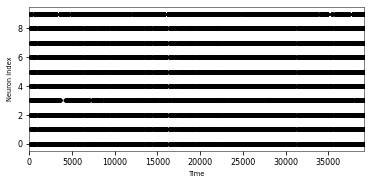

In [39]:

output_spikes = output.get_data(variables=["spikes"])
post_neo = post_alif_pop.get_data(variables=["spikes"])
post_spikes = post_neo.segments[0].spiketrains
pre_v = pre_alif_pop.get_data("v")
post_v = post_alif_pop.get_data("v")
#print(stdp_projection.getWeights())

plot.Figure(
    plot.Panel(output_spikes.segments[0].spiketrains,yticks=True,xticks=True,xlabel="Time"),
).save("OutputSpikes")

In [40]:

weightarray = np.array(stdp_projection.getWeights())
print(weightarray)
for l in range(0,batchsize):
    for i in range(0,9):#neurons
        counter = 0
        count=len(output_spikes.segments[0].spiketrains[i])
        #print(count)
        for j in range(0,count):#
            if output_spikes.segments[0].spiketrains[i][j]:
                counter+=1
                if counter >=10:
                    if i == Labels[l+30]:
                        weightarray[i] += 0.13
                        if weightarray[i] >= 5:
                            weightarray[i] = 5
                        break
                        
                    else:
                        weightarray[i] -= 0.23
                        if weightarray[i] <= 0:
                            weightarray[i] = 0
                            weightarray[i] += 0.1
                        break
                        
print(weightarray)

2022-05-28 12:07:11 WARNING: getWeights is deprecated.  Use get('weight') instead
Getting synaptic data between PostAlif and PostAlif1
|0%                          50%                         100%|

[5.       5.       5.       4.984375 5.       5.       5.       5.
 5.       5.       5.       5.       5.       4.984375 5.       5.
 5.       5.       5.       5.       5.       5.       5.       4.984375
 5.       5.       5.       5.       5.       5.       5.       5.
 5.       4.984375 5.       5.       5.       5.       5.       5.
 5.       5.       5.       4.984375 5.       5.       5.       5.
 5.       5.       5.       5.       5.       4.984375 5.       5.
 5.       5.       5.       5.       5.       5.       5.       4.984375
 5.       5.       5.       5.       5.       5.       5.       5.
 5.       4.984375 5.       5.       5.       5.       5.       5.
 5.       5.       5.       4.984375 5.       5.       5.       5.
 5.       5.       5.       5.       5.       4.984375 5.       5.
 5.       5.       5.       5.       5.       5.       5.       4.984375
 5.       5.       5.       5.       5.       5.       5.       5.
 5.       4.984375 5.       5.       5.     

In [50]:
import numpy as np
N_digits = 5
#N_digits = 60000
D_Size = 784
D_bytes = N_digits * D_Size
D_rows = N_digits * 28

MNIST_file = open ("train-images.idx3-ubyte","rb")
z = MNIST_file.read (16 + D_bytes)
len (z)
digits_raw = z[16:(16 + D_bytes)]
w = np.empty (shape=(D_rows, 28))
print (len (digits_raw))
for i in range (0, D_rows) :
    for j in range (0,28) :
        w[i, j] = float (digits_raw[i*28 + j])/255
Training = w.reshape (N_digits, 28, 28)
np.shape (Training)
counter = 0
spikearray = []
spike_array = []
#print(Training[0])
for i in range(4,len(Training)):
    for j in range(0,28):
        for k in range(0,28):
            if Training[i,j,k] >= 0.5:
                Training[i,j,k] = counter
                spike_array.append(Training[i,j,k])
            else:
                Training[i,j,k] = 0
            counter+=1
spikearray = spike_array
print(spikearray)
Labels_file = open ("train-labels.idx1-ubyte","rb")
Labels_raw = Labels_file.read (8 + N_digits)
Labels = np.empty (N_digits)
for i in range (0, N_digits):
    Labels[i] = int (Labels_raw[8 + i])
# The classes of the digits, 0:9
Answers = range (0, 10)

#Labels = to_categorical(Labels)
#print(Labels[0])
#print(Training[0])

3920
[209.0, 210.0, 211.0, 212.0, 215.0, 236.0, 237.0, 238.0, 239.0, 240.0, 241.0, 242.0, 243.0, 244.0, 263.0, 264.0, 265.0, 269.0, 270.0, 271.0, 290.0, 291.0, 292.0, 297.0, 298.0, 299.0, 316.0, 317.0, 318.0, 319.0, 324.0, 325.0, 326.0, 344.0, 345.0, 346.0, 352.0, 353.0, 354.0, 371.0, 372.0, 373.0, 378.0, 379.0, 380.0, 381.0, 399.0, 400.0, 404.0, 405.0, 406.0, 407.0, 408.0, 427.0, 428.0, 429.0, 430.0, 431.0, 432.0, 433.0, 434.0, 435.0, 436.0, 456.0, 457.0, 458.0, 459.0, 462.0, 463.0, 464.0, 490.0, 491.0, 518.0, 519.0, 546.0, 547.0, 574.0, 575.0, 602.0, 603.0, 630.0, 631.0, 658.0, 659.0, 687.0, 688.0, 715.0, 716.0, 717.0, 744.0, 745.0]


In [51]:

#print(Training[8])
import spynnaker8 as sim
import pyNN.utility.plotting as plot
import matplotlib.pyplot as plt


batchsize = N_digits
simtime = 28*28*batchsize
#simtime = 750*batchsize*2
n_neurons = 100
sim.setup(timestep=1,time_scale_factor=10)
input_neuron_count = 784

pre_alif_pop = sim.Population(n_neurons,
                              sim.IF_cond_exp(**ALIF_neuron_parameters_inh),
                              initial_values={'v': ALIF_neuron_parameters_inh["v_rest"]},label="PreAlif")
post_alif_pop = sim.Population(n_neurons, 
                               sim.IF_cond_exp(**ALIF_neuron_parameters_exc),
                               initial_values={'v': ALIF_neuron_parameters_exc["v_rest"]},label="PostAlif")

pre_alif_pop.record(["spikes",'v','gsyn_inh','gsyn_exc'])
post_alif_pop.record(["spikes",'v','gsyn_exc','gsyn_inh'])

%matplotlib inline

inp = sim.Population(input_neuron_count,
                   sim.SpikeSourceArray(spikearray),
                   label="Input"
                  )
output = sim.Population(10,
                    sim.IF_cond_exp(**ALIF_neuron_parameters_exc),
                    initial_values={'v': ALIF_neuron_parameters_exc["v_rest"]},label="PostAlif"
                    )
output.record(["spikes"])
stdp_initial_weights = sim.RandomDistribution(distribution='normal_clipped',low=0,high=1, mu=0.5, sigma=0.3)
sim.Projection(presynaptic_population = post_alif_pop,
             postsynaptic_population = pre_alif_pop,
             connector = sim.OneToOneConnector(),
             synapse_type = sim.StaticSynapse(weight=1,delay=1.0),
             receptor_type = 'excitatory'
            )
i_e_connection_list = []
for i in range(n_neurons):
    for j in range(n_neurons):
        if not i==j:
            i_e_connection_list.append((i,j))
sim.Projection(presynaptic_population = pre_alif_pop,
             postsynaptic_population = post_alif_pop,
             connector = sim.FromListConnector(i_e_connection_list),
             synapse_type = sim.StaticSynapse(weight=0.0625,delay=1.0), # 0.0001
             receptor_type = 'inhibitory'
            )
sim.Projection(post_alif_pop,post_alif_pop,sim.AllToAllConnector(),
               synapse_type=sim.StaticSynapse(weight=0.285),
               receptor_type = 'excitatory')#recurrent
sim.Projection(pre_alif_pop,pre_alif_pop,sim.AllToAllConnector(),
               synapse_type=sim.StaticSynapse(weight=0.65),
               
               receptor_type = 'inhibitory')#recurrent
sim.Projection(inp,post_alif_pop,
                sim.AllToAllConnector(),
                synapse_type=sim.StaticSynapse(weight=0.65),
                receptor_type = 'inhibitory')

timing_rule = sim.SpikePairRule(tau_plus=5.0,
                                tau_minus=2.0,
                                A_plus=0.0625,
                                A_minus=0.0625)
weight_rule = sim.AdditiveWeightDependence(w_max=5.0,w_min=0.0)
stdp_model = sim.STDPMechanism(timing_dependence=timing_rule,
                               weight_dependence=weight_rule,
                              weight=weightarray,delay=3.0)
stdp_projection = sim.Projection(post_alif_pop,
                                 output,
                                 sim.AllToAllConnector(),
                                 synapse_type=stdp_model,
                                 receptor_type = 'excitatory')
sim.Projection(post_alif_pop,post_alif_pop,sim.AllToAllConnector(),synapse_type=sim.StaticSynapse(weight=0.185),receptor_type = 'excitatory')#recurrent
sim.Projection(pre_alif_pop,pre_alif_pop,sim.AllToAllConnector(),synapse_type=sim.StaticSynapse(weight=0.15),receptor_type = 'inhibitory')#recurrent
sim.run(simtime)

2022-05-28 12:19:22 WARNING: Calling setup a second time causes the previous simulator to be stopped and cleared.
2022-05-28 12:19:22 INFO: Caching data for segment -1
Getting spikes for PreAlif
|0%                          50%                         100%|
Getting v for PreAlif
|0%                          50%                         100%|
Getting gsyn_exc for PreAlif
|0%                          50%                         100%|
Getting gsyn_inh for PreAlif
|0%                          50%                         100%|
2022-05-28 12:19:22 INFO: Caching data for segment -1
Getting spikes for PostAlif
|0%                          50%                         100%|
Getting v for PostAlif
|0%                          50%                         100%|
Getting gsyn_exc for PostAlif
|0%                          50%                         100%|
Getting gsyn_inh for PostAlif
|0%                          50%                         100%|
2022-05-28 12:19:22 INFO: Caching data for segment -1
Ge

['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']


2022-05-28 12:19:25 INFO: Time 0:00:03.219562 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2022-05-28 12:19:35 INFO: Time 0:00:09.851493 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2022-05-28 12:19:40 INFO: Time 0:00:05.516550 taken by SpYNNakerSplitterPartitioner
Created spalloc job 6439786
2022-05-28 12:19:40 INFO: Created spalloc job 6439786
Waiting for board power commands to complete.
2022-05-28 12:19:40 INFO: Waiting for board power commands to complete.
2022-05-28 12:19:45 INFO: Time 0:00:05.050037 taken by SpallocAllocator
2022-05-28 12:19:45 INFO: Creating transceiver for 10.11.218.33
2022-05-28 12:19:45 INFO: Working out if machine is booted
2022-05-28 12:19:49 INFO: Attempting to 

3920.0

Getting spikes for PostAlif1
|0%                          50%                         100%|
Getting spikes for PostAlif
|0%                          50%                         100%|
Getting v for PreAlif
|0%                          50%                         100%|
Getting v for PostAlif
|0%                          50%                         100%|


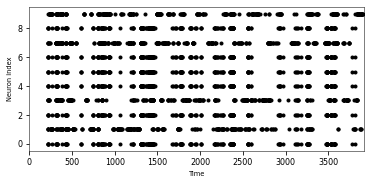

In [52]:

output_spikes = output.get_data(variables=["spikes"])
post_neo = post_alif_pop.get_data(variables=["spikes"])
post_spikes = post_neo.segments[0].spiketrains
pre_v = pre_alif_pop.get_data("v")
post_v = post_alif_pop.get_data("v")
#print(stdp_projection.getWeights())

plot.Figure(
    plot.Panel(output_spikes.segments[0].spiketrains,yticks=True,xticks=True,xlabel="Time"),
).save("OutputSpikes")

In [58]:
#print(output_spikes.segments[0].spiketrains[1])
for i in range (0,10):
    print(i,":",len(output_spikes.segments[0].spiketrains[i]))

0 : 287
1 : 367
2 : 287
3 : 351
4 : 287
5 : 287
6 : 287
7 : 471
8 : 287
9 : 437


In [62]:
print(Labels[4])

9.0
